In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import matplotlib.pyplot as plt
from ska_pst_stat import Statistics
from ska_pst_stat.utility import Hdf5FileGenerator, StatConfig

## Generate a test file

The following shows how to generate a test file that can then be used to display the statistics

First create a file path and file name

In [3]:
output_file = pathlib.Path() / "test.h5"

# ensure the file doesn't exist before creating it
if output_file.exists():
    output_file.unlink()

Create an instance of a Hdf5FileGenerator. This is an example of a MID telescope scan

In [4]:
generator = Hdf5FileGenerator(
    file_path=output_file,
    eb_id="eb-m001-20230921-245",
    telescope="SKAMid",
    scan_id=42,
    beam_id="1",
    config=StatConfig(nheap=16, ntime_bins=32, nbit=8, nchan=555)
)

Generate the HDF5 file

In [5]:
generator.generate()

Assert the file now exists

In [6]:
assert output_file.exists()

## Use STAT file to view statistics

Everything below now assumes that the file was generated by `STAT.CORE`

The first thing to do is load the statistics from the given file path.

In [7]:
stats = Statistics.load_from_file(file_path=output_file)

Display the scalar header fields.

In [8]:
stats.header

,Key,Value
0,File Format Version,1.0.0
1,Execution Block ID,eb-m001-20230921-245
2,Telescope,SKAMid
3,Scan ID,42
4,Beam ID,1
5,UTC Start Time,2023-10-23-11:00:00
6,Scan Scan Offset,0.0
7,End Scan Offset,0.106168
8,Frequency (MHz),87.5
9,Bandwidth (MHz),75.0


## View frequency averaged stats

View the frequency averaged stats for all frequencies

This returns a Pandas data frame with a multi-index key of polarisation and complex voltage dimension

In [9]:
df = stats.frequency_averaged_stats
df

Mean      Var.  Clipped
Polarisation Dimension                             
A            Real       0.000235  0.998270      884
             Imag       0.002552  0.998023      836
B            Real       0.001184  0.990096      836
             Imag      -0.001824  0.996612      872

To view the data with RFI excised, use the `frequency_averaged_stats_rfi_excised` property (Note in this example there has been no RFI excision)

In [10]:
df = stats.frequency_averaged_stats_rfi_excised
df

Mean      Var.  Clipped
Polarisation Dimension                             
A            Real       0.000235  0.998269      884
             Imag       0.002552  0.998023      836
B            Real       0.001184  0.990096      836
             Imag      -0.001824  0.996612      872

## View per channel level statistics

There are 6 properties that can be used to get channel level statistics; 3 for each polariation.  Within each polarisation you can get the combined complex data or you can select the real or imaginary data.

* pol_a_channel_stats
* pol_a_real_channel_stats
* pol_a_imag_channel_stats
* pol_b_channel_stats
* pol_b_real_channel_stats
* pol_b_imag_channel_stats

For example so view all of the polarisation A channel stats:

In [11]:
df = stats.pol_a_channel_stats
df

Channel Freq (MHz)      Mean      Var.  Clipped
Channel Dimension                                                 
0       Real                50.067568 -0.054520  1.049696        3
        Imag                50.067568 -0.042709  1.070972        0
1       Real                50.202703  0.001419  1.057266        2
        Imag                50.202703  0.057816  1.009323        2
2       Real                50.337838 -0.004944  1.012397        1
...                               ...       ...       ...      ...
552     Imag               124.662162 -0.021286  0.945328        2
553     Real               124.797297  0.006363  0.945858        3
        Imag               124.797297 -0.066193  0.911079        2
554     Real               124.932432  0.071823  0.979511        1
        Imag               124.932432 -0.092514  1.027819        0

[1110 rows x 4 columns]

or to view say only the real valued data from polarisation B:

In [12]:
df = stats.pol_b_real_channel_stats
df

,Channel,Channel Freq (MHz),Mean,Var.,Clipped
0,0,50.067568,-0.025177,0.928793,0
1,1,50.202703,-0.031998,0.997467,0
2,2,50.337838,0.009338,0.934604,4
3,3,50.472973,-0.009567,1.179878,2
4,4,50.608108,0.024399,0.973709,1
...,...,...,...,...,...
550,550,124.391892,0.047745,1.054058,1
551,551,124.527027,-0.026962,1.061300,2
552,552,124.662162,0.070908,1.041156,0
553,553,124.797297,0.008514,1.068209,1


## Spectral power statistics

The STAT file includes the mean and max spectral power for each channel over the time the STAT file performs the calculations. This is recorded for each polarisation and can be accessed by the following properties

* pol_a_spectral_power
* pol_b_spectral_power

The following shows accessing both properties

In [13]:
df = stats.pol_a_spectral_power
df

,Channel,Mean,Max
0,0,2.121323,12.553528
1,1,2.065897,11.123657
2,2,1.996208,11.440063
3,3,2.001794,11.351624
4,4,1.896061,9.501526
...,...,...,...
550,550,1.957926,11.672974
551,551,1.964688,13.164368
552,552,1.943653,9.494934
553,553,1.857731,10.529846


In [14]:
df = stats.pol_b_spectral_power
df

,Channel,Mean,Max
0,0,1.888862,12.933655
1,1,2.040846,12.667236
2,2,1.916655,15.768127
3,3,2.178327,11.382935
4,4,1.941046,12.116821
...,...,...,...
550,550,2.107539,17.442993
551,551,2.077548,11.111572
552,552,2.110156,14.155334
553,553,2.058329,10.178833


Below is an example of using the above data frames can be to find which channel has the overall maximum power (such as ones that have RFI).

In this case Channel 409 has the maximum spectral power.

In [15]:
df.iloc[df["Max"].idxmax()]

Channel    166.000000
Mean         2.057636
Max         18.000000
Name: 166, dtype: float64

## Histogram Data (non-rebinned)

There are 8 histogram data frames that can be extracted from the STAT file. These are made up of the permutations of different polarisations, real vs imag data, and all channels or just the channels that don't have RFI.

* pol_a_real_histogram
* pol_a_imag_histogram
* pol_a_real_histogram_rfi_excised
* pol_a_imag_histogram_rfi_excised
* pol_b_real_histogram
* pol_b_imag_histogram
* pol_b_real_histogram_rfi_excised
* pol_b_imag_histogram_rfi_excised

As an example the following is for imaginary component of polarisation A.

In [16]:
df = stats.pol_a_imag_histogram
df

,Bin,Count
0,0,402
1,1,33
2,2,32
3,3,38
4,4,32
...,...,...
251,251,44
252,252,46
253,253,40
254,254,32


To plot the histogram data, use something like the following from Matplotlib

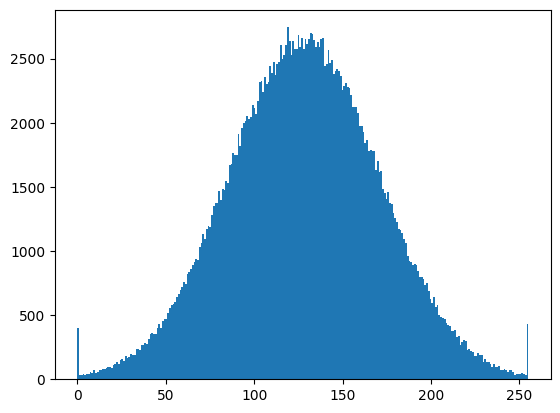

In [17]:
plt.hist(df["Bin"], bins=256, weights=df["Count"])
plt.show()

## Histogram Data (Rebinned)

The data may also rebinned to a finer number of bins. There are also 1D histograms (as above) but there are 4 2D histograms; this is a combination of polarisation and all or just rfi excised data.

### Available 1D histograms

* pol_a_real_rebinned_histogram
* pol_a_imag_rebinned_histogram
* pol_a_real_rebinned_histogram_rfi_excised
* pol_a_imag_rebinned_histogram_rfi_excised
* pol_b_real_rebinned_histogram
* pol_b_imag_rebinned_histogram
* pol_b_real_rebinned_histogram_rfi_excised
* pol_b_imag_rebinned_histogram_rfi_excised

Plotting the above histograms are similar to the non-rebinned 1D histograms

### Available 2D histograms

* pol_a_rebinned_histogram2d
* pol_b_rebinned_histogram2d
* pol_a_rebinned_histogram2d_rfi_excised
* pol_b_rebinned_histogram2d_rfi_excised

An example of plotting a 2D histogram is as follows.  Note that in the 2D case we get a Numpy array not Pandas data frame

In [18]:
hist2d = stats.pol_b_rebinned_histogram2d
hist2d

array([[1, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]], dtype=uint32)

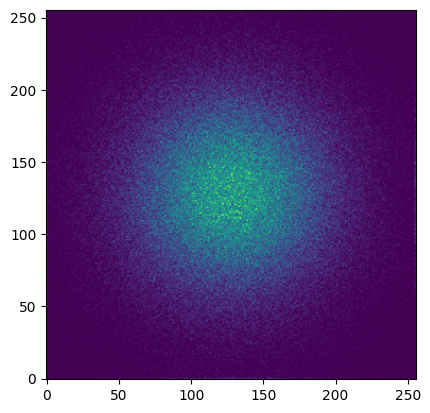

In [19]:
plt.imshow(hist2d, origin='lower')
plt.show()

## Spectrograms

The STAT data also includes spectrogram data for both polarisations.  The following properties are available as spectrograms:

* pol_a_spectrogram
* pol_b_spectrogram

Below is an example of how to plot the spectrogram

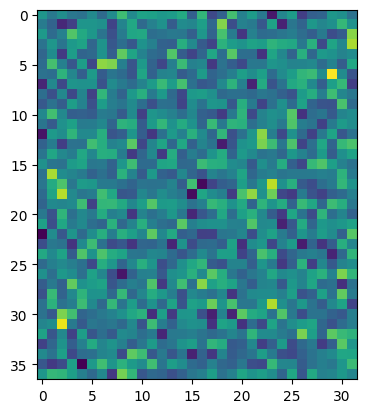

In [20]:
plt.imshow(stats.pol_a_spectrogram)
plt.show()

## Timeseries data

The STAT data provides a timeseries data. This is per temporal bin in the spectrogram that all the power of all frequencies are combined.  There are 4 timeseries data frames based on the 2 polarisations and all frequencies or just of the RFI excised data.

* pol_a_timeseries
* pol_b_timeseries
* pol_a_timeseries_rfi_excised
* pol_b_timeseries_rfi_excised

The timeseries data reports max, min, and mean power per temporal bin.

The following is an example of plotting the time series data. Note that there is an extra column of the `Time offset` that is used to give a time scale on the X axis.

In [21]:
df = stats.pol_a_timeseries_rfi_excised
df

,Time offset,Max,Min,Mean
Temporal bin,,,,
0,0.001659,15.874146,0.001099,1.936821
1,0.004977,16.648682,0.000549,2.004352
2,0.008294,15.526428,0.000000,2.021572
3,0.011612,15.032043,0.000549,1.997549
4,0.014930,16.910156,0.000000,2.010229
5,0.018248,14.687622,0.000000,1.984229
6,0.021565,17.859924,0.000000,2.046872
7,0.024883,15.289124,0.000000,1.979526
8,0.028201,16.508606,0.000549,2.004024


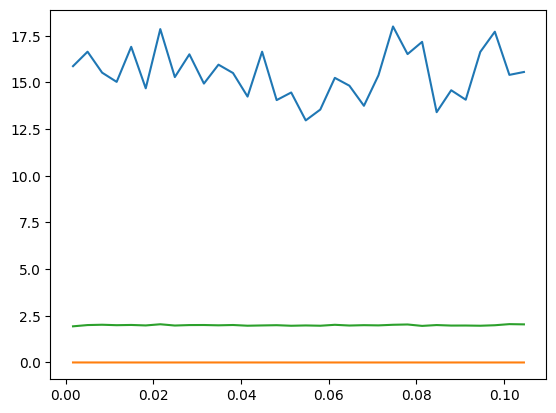

In [22]:
plt.plot(df["Time offset"], df[["Max", "Min", "Mean"]])
plt.show()